## GSE270288 – Evidence for a role of human blood-borne factors in mediating age-associated changes in molecular circadian rhythms

- collected blood from apparently healthy young (age 25-30) and old (age 70-76) individuals at 14:00
- serum was used to synchronize cultured fibroblasts
- We did not observe a global difference in the distribution of phase between groups, but found that peak expression of several clock-controlled genes (PER3, NR1D1, NR1D2, CRY1, CRY2, and TEF) lagged in the cells synchronized ex vivo with old serum.
- https://pubmed.ncbi.nlm.nih.gov/39485282/


In [ ]:
import COFE.analyse
import COFE.scpca
import COFE.plot
import numpy as np
import anndata as ad
import pandas as pd
import PCA_func as pc
import matplotlib.pyplot as plt

### Step 1: Open the dataset

In [141]:
path = '/Users/maksimsgolubovics/Python_VScode/Studienprojekt/rnaseq_datasets/GSE270288_rnaseq.h5ad'
adata = ad.read_h5ad(path)

#Transform to DataFrame
data_df = pd.DataFrame(data=adata.X, columns=adata.var.index, index=adata.obs.index).T

#Look at sampeles features
adata.var[['tissue', 'cell_line', 'cell_type', 'genotype', 'treatment', 'time', 'subject']]
adata.var['time'] = adata.var['time'].astype(int) - 32
adata.var['time'] = adata.var['time'].replace([24,26],[0,2])
adata.var['time'].unique()

array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22])

### Step 2: Prepare the dataset

In [142]:
data_df_log = np.log10(data_df + 0.1) #Logarithmic transformation

### Step 3: Exploratory analysis

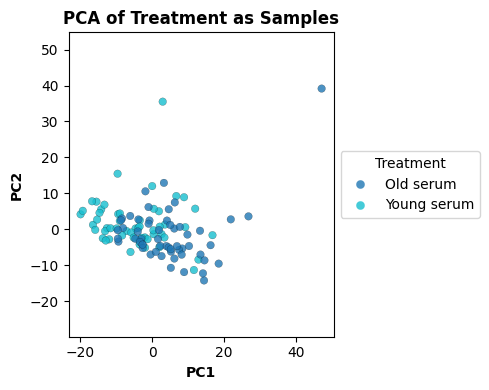

In [16]:
data_df_log_time = data_df_log.join(adata.var['treatment']).reset_index().set_index('treatment').drop('index', axis=1)
pc.principal_component_2d_timesample(data=data_df_log_time, label='Treatment', c_map='tab10')

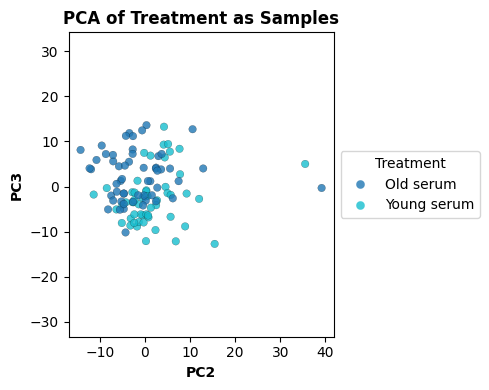

In [17]:
data_df_log_time = data_df_log.join(adata.var['treatment']).reset_index().set_index('treatment').drop('index', axis=1)
pc.principal_component_2d_timesample(data=data_df_log_time, x=2, y=3, label='Treatment', c_map='tab10')

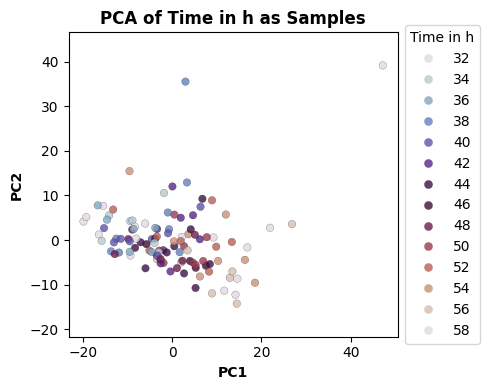

In [15]:
data_df_log_time = data_df_log.join(adata.var['time']).reset_index().set_index('time').drop('index', axis=1)
pc.principal_component_2d_timesample(data=data_df_log_time, label='Time in h', c_map='twilight')

### Step 4: Identify mean and std threshold values

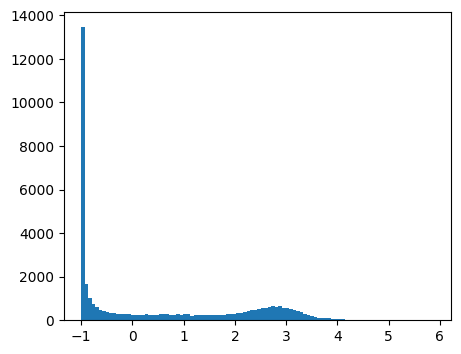

In [19]:
plt.figure(figsize=(5, 4))
plt.hist(x=data_df_log.mean(), bins=100);

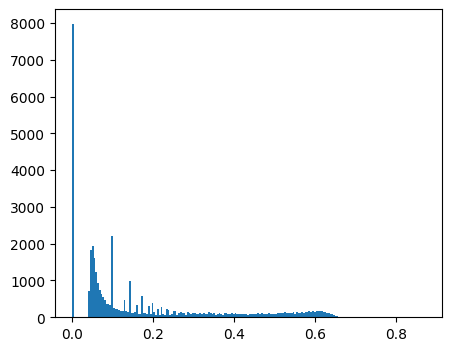

In [20]:
plt.figure(figsize=(5, 4))
plt.hist(x=data_df_log.std(), bins=200);

### Step 5: COFE

#### COFE Young Serum

In [143]:
X_train_a = data_df_log[(adata.var['treatment'] == 'Young serum')]
true_time_train_a = adata.var[(adata.var['treatment'] == 'Young serum')]['time'].astype(float)

X_train_a, X_test_a, features_a, features_std_a = COFE.analyse.preprocess_data(X_train_a.to_numpy(), None, 
                                                                           features=X_train_a.columns, feature_dim='col',
                                                                           mean_threshold=1, scaling_threshold=15)
X_train_a.shape # (Samples, Transcripts)

(54, 5090)

In [144]:
s_choices = np.linspace(1, 50, 15)
cv_a = COFE.analyse.cross_validate(X_train_a, s_choices, features=features_a, K=5, ncores=-1, restarts=10)

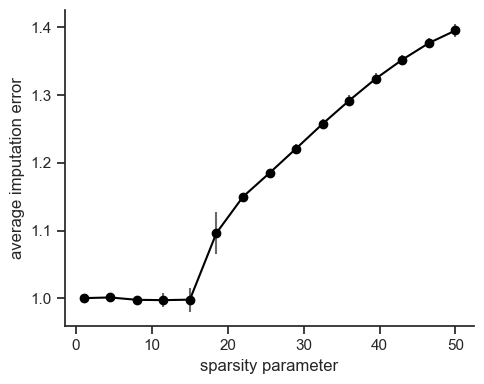

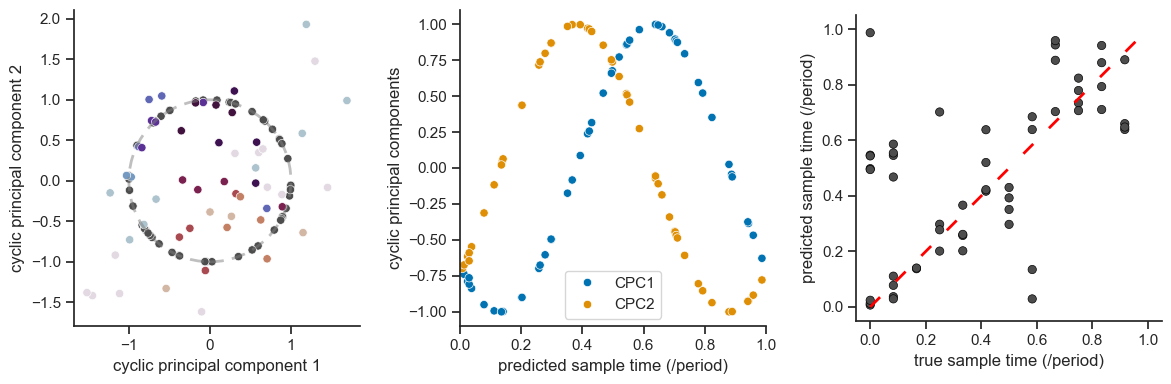

In [146]:
results_train_a = COFE.analyse.predict_time(X_train_a, cv_a, true_times=true_time_train_a.to_numpy(), period=24)
COFE.plot.plot_cv_run(results_train_a, figsize=(5,4))
COFE.plot.plot_circular_ordering(results_train_a, time=true_time_train_a.to_numpy(), X=X_train_a, figsize=(12, 4), period=24)

In [147]:
results_train_a["MAPE"]*24

np.float64(1.7979328028985453)

#### COFE Old Serum

In [111]:
X_train_b = data_df_log[(adata.var['treatment'] == 'Old serum')]
true_time_train_b = adata.var[(adata.var['treatment'] == 'Old serum')]['time'].astype(float)

X_train_b, X_test_b, features_b, features_std_b = COFE.analyse.preprocess_data(X_train_b.to_numpy(), None, 
                                                                           features=X_train_b.columns, feature_dim='col', 
                                                                           mean_threshold= 1,scaling_threshold=12)
X_train_b.shape # (Samples, Transcripts)

(55, 4251)

In [125]:
s_choices = np.linspace(1, 50, 15)
cv_b = COFE.analyse.cross_validate(X_train_b, s_choices, features=features_b, K=4, ncores=-1, repeats=3, restarts=10)

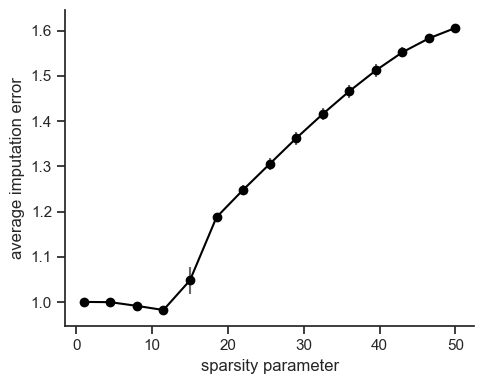

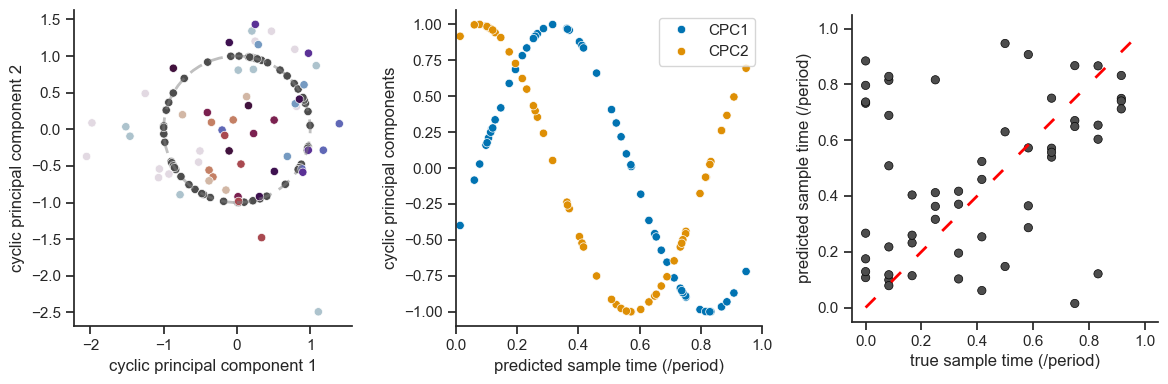

In [126]:
results_train_b = COFE.analyse.predict_time(X_train_b, cv_b, true_times=true_time_train_b.to_numpy(), period=24)
COFE.plot.plot_cv_run(results_train_b, figsize=(5,4))
COFE.plot.plot_circular_ordering(results_train_b, time=true_time_train_b.to_numpy(), X=X_train_b, figsize=(12, 4), period=24)

In [127]:
results_train_b["MAPE"]*24

np.float64(3.3166831258255254)

#### COFE Young and Old Serum

In [100]:
X_train_c = data_df_log
true_time_train_c = adata.var['time'].astype(float)

X_train_c, X_test_c, features_c, features_std_c = COFE.analyse.preprocess_data(X_train_c.to_numpy(), None, 
                                                                           features=X_train_c.columns, feature_dim='col', 
                                                                           mean_threshold= 1,scaling_threshold=15)
X_train_c.shape # (Samples, Transcripts)

(109, 6392)

In [137]:
s_choices = np.linspace(1, 50, 15)
cv_c = COFE.analyse.cross_validate(X_train_c, s_choices, features=features_c, K=4, ncores=-1, repeats=3, restarts=10)

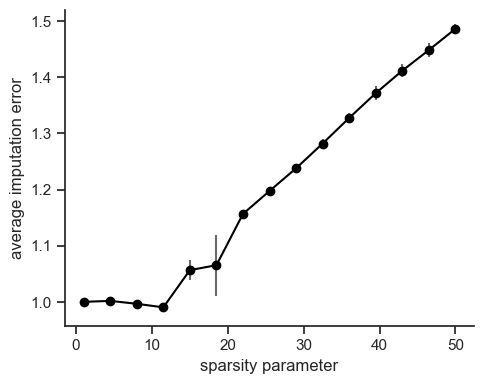

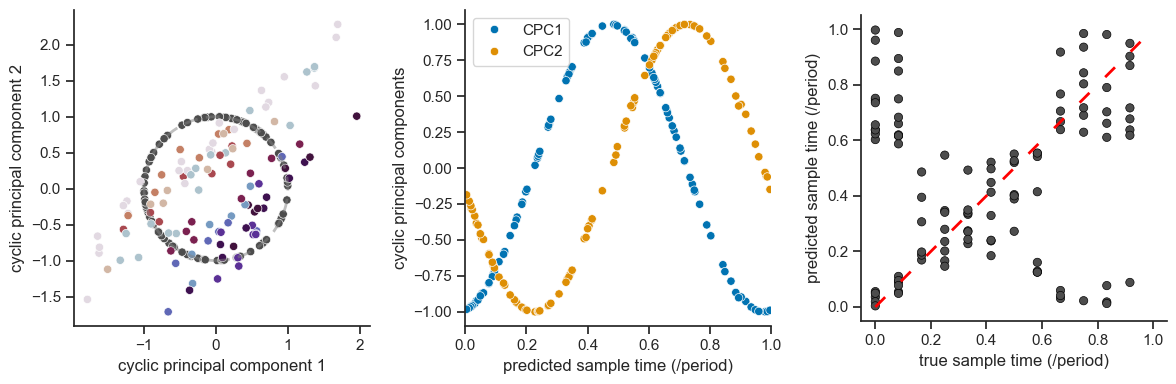

In [138]:
results_train_c = COFE.analyse.predict_time(X_train_c, cv_c, true_times=true_time_train_c.to_numpy(), period=24)
COFE.plot.plot_cv_run(results_train_c, figsize=(5,4))
COFE.plot.plot_circular_ordering(results_train_c, time=true_time_train_c.to_numpy(), X=X_train_c, figsize=(12, 4), period=24)

In [139]:
results_train_c["MAPE"]*24

np.float64(2.5047644591948037)

## Conclusion

From the Study:

We find that while the number of rhythmic transcripts (weighted BIC > 0.75) in the young serum condition (~18%) is higher than the old serum condition (~12%), both conditions demonstrate a much larger number of cycling transcripts in these cultured fibroblasts than in other cell culture studies (Duffield et al., 2002; Grundschober et al., 2001; Hughes et al., 2009; Jang et al., 2015). In mammals, up to 20% of transcripts can cycle in a given tissue (Patel et al., 2012; Zhang et al., 2014), and the low number of cycling transcripts in culture has been cited as a major limitation of the culture model (Hughes et al., 2009).

However, a major contributing factor to the high rhythmicity might be the use of human serum as the synchronization signal. In this way, our model of mimicking signaling to peripheral tissues by using serum directly from humans may more accurately recapitulate the human condition.

- Sadly they haven't had control group without serum treatment, or group with dexamethasone as standart for cycadian synchronization

COFE shows a decent result here. There is somewhat logical observation: the more controlled the experiment is, as in this case where we have a specific cell line incubated under certain constant conditions, more precise the results for smaller group sizes are. In contrast, COFE performs poorly in the studies that have collected sequence data directly from human tissue in the case of skeletal muscle, such as GSE129843 here and GSE182117 here. My guess is that unknown sigle individual variation or batch effects takes place. But back to this study, the COFE on samples with young serum compared to old serum performed way better, which was somewhat expected and in coordinance with findings in the study. 
